In [60]:
'''
Things which can go wrong:
-Kernel size of 3 instead of 4 in second layer of prep network.
-Learning Rate Scheduler.
-Increasing Batch Size OR reducing dataset size.
'''

'\nThings which can go wrong:\n-Kernel size of 3 instead of 4 in second layer of prep network.\n-Learning Rate Scheduler.\n-Increasing Batch Size OR reducing dataset size.\n'

In [61]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
%matplotlib inline

In [63]:
dataset_path = '../tiny-imagenet-200/MultiImageSteganography'
train_csv = 'train_dataset.csv'
valid_csv = 'validation_dataset.csv'
train_folder = 'train/'
validation_folder = 'valid/'

In [64]:
IMG_SIZE = 64
LEARNING_RATE  = 0.001
COVER_LOSS_WEIGHT = 1
SECRET_LOSS_WEIGHT = 1
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4
EPOCHS = 50

In [65]:
transformations = {
    'train_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()]),
    'valid_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()])
}

class SteganoDataset(torch.utils.data.Dataset):
    def __init__(self,dataset_csv,transforms,type_of_dataset):
        self.dataset = pd.read_csv(dataset_csv)
        self.dataset = self.dataset.reset_index(drop=True)
        self.transforms = transforms
        self.type = type_of_dataset
    
    def __getitem__(self,index):
        cover_image = self.dataset.iloc[index]['cover_image']
        secret_image1 = self.dataset.iloc[index]['secret_image_1']
        secret_image2 = self.dataset.iloc[index]['secret_image_2']
        secret_image3 = self.dataset.iloc[index]['secret_image_3']
        
        cover_image = Image.open(os.path.join(dataset_path,self.type,cover_image))
        secret_image1 = Image.open(os.path.join(dataset_path,self.type,secret_image1))
        secret_image2 = Image.open(os.path.join(dataset_path,self.type,secret_image2))
        secret_image3 = Image.open(os.path.join(dataset_path,self.type,secret_image3))
        
        transformed_cover_image = self.transforms(cover_image)
        transformed_secret_image_1 = self.transforms(secret_image1)
        transformed_secret_image_2 = self.transforms(secret_image2)
        transformed_secret_image_3 = self.transforms(secret_image3)
        
        if self.type == 'train':
            return {
                'cover_image':transformed_cover_image,
                'secret_image_1':transformed_secret_image_1,
                'secret_image_2':transformed_secret_image_2,
                'secret_image_3':transformed_secret_image_3
            }
        else:
            return {
                'cover_image':transformed_cover_image,
                'secret_image_1':transformed_secret_image_1*255,
                'secret_image_2':transformed_secret_image_2*255,
                'secret_image_3':transformed_secret_image_3*255
            }
    
    def __len__(self):
        return len(self.dataset)

In [66]:
class PrepNetwork1(nn.Module):
    def __init__(self):
        super(PrepNetwork1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image
    
class PrepNetwork2(nn.Module):
    def __init__(self):
        super(PrepNetwork2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image
    
class PrepNetwork3(nn.Module):
    def __init__(self):
        super(PrepNetwork3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image

class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=198,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=198,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=198,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
        
    def forward(self,secret_image_1,secret_image_2,secret_image_3,cover_image):
        concatenated_secrets = torch.cat([cover_image,secret_image_1,secret_image_2,secret_image_3],dim=1)
        
        output_1 = F.relu(self.conv1(concatenated_secrets))
        output_2 = F.relu(self.conv2(concatenated_secrets))
        output_3 = F.relu(self.conv3(concatenated_secrets))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_converted_image = F.relu(self.final_layer(concat_5))
        
        return output_converted_image
        

In [67]:
class Encoder(nn.Module):
    def __init__(self,prep_network_1,prep_network_2,prep_network_3,hiding_network):
        super(Encoder, self).__init__()
        self.prep_network1 = prep_network_1
        self.prep_network2 = prep_network_2
        self.prep_network3 = prep_network_3
        self.hiding_network = hiding_network
    
    def forward(self,cover_image,secret_image_1,secret_image_2,secret_image_3):
        encoded_secret_image_1 = self.prep_network1(secret_image_1)
        encoded_secret_image_2 = self.prep_network2(secret_image_2)
        encoded_secret_image_3 = self.prep_network3(secret_image_3)
        
        hidden_image = self.hiding_network(encoded_secret_image_1,
                                           encoded_secret_image_2,
                                           encoded_secret_image_3,
                                           cover_image
                                          )
        hidden_image = (0.01**0.5)*torch.randn(hidden_image.size(),device=device)
        return hidden_image

In [68]:
class RevealNetwork1(nn.Module):
    def __init__(self):
        super(RevealNetwork1,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image
    
class RevealNetwork2(nn.Module):
    def __init__(self):
        super(RevealNetwork2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image

class RevealNetwork3(nn.Module):
    def __init__(self):
        super(RevealNetwork3,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image 

In [69]:
class Decoder(nn.Module):
    def __init__(self,reveal_network_1,reveal_network_2,reveal_network_3):
        super(Decoder, self).__init__()
        self.reveal_network_1 = reveal_network_1
        self.reveal_network_2 = reveal_network_2
        self.reveal_network_3 = reveal_network_3
    
    def forward(self,hidden_image):
        reveal_image_1 = self.reveal_network_1(hidden_image)
        reveal_image_2 = self.reveal_network_2(hidden_image)
        reveal_image_3 = self.reveal_network_3(hidden_image)
        return reveal_image_1,reveal_image_2,reveal_image_3

In [70]:
class SteganoModel(nn.Module):
    def __init__(self,encoder,decoder):
        super(SteganoModel,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self,cover_image,secret_image_1,secret_image_2,secret_image_3):
        hidden_image = self.encoder(cover_image,secret_image_1,secret_image_2,secret_image_3)
        reveal_image_1,reveal_image_2,reveal_image_3 = self.decoder(hidden_image)
        return hidden_image,reveal_image_1,reveal_image_2,reveal_image_3

In [71]:
prep_1 = PrepNetwork1()
prep_2 = PrepNetwork2()
prep_3 = PrepNetwork3()
hiding_network = HidingNetwork()

encoder = Encoder(prep_1,prep_2,prep_3,hiding_network)


reveal_1 = RevealNetwork1()
reveal_2 = RevealNetwork2()
reveal_3 = RevealNetwork3()

decoder = Decoder(reveal_1,reveal_2,reveal_3)

model = SteganoModel(encoder,decoder)
model.to(device)

SteganoModel(
  (encoder): Encoder(
    (prep_network1): PrepNetwork1(
      (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv6): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (prep_network2): PrepNetwork2(
      (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [72]:
class SteganoLoss(nn.Module):
    def __init__(self,cover_weight,secret_weight):
        super(SteganoLoss,self).__init__()
        self.cover_weight = cover_weight
        self.secret_weight = secret_weight
        
    def forward(self,predicted_cover_image,cover_image,
               predicted_secret_image_1,secret_image_1,
               predicted_secret_image_2,secret_image_2,
               predicted_secret_image_3,secret_image_3):
    
        cover_loss = self.cover_weight*(F.mse_loss(predicted_cover_image,cover_image))
        secret_loss = self.secret_weight*(F.mse_loss(predicted_secret_image_1,secret_image_1)) + self.secret_weight*(F.mse_loss(predicted_secret_image_2,secret_image_2)) + self.secret_weight*(F.mse_loss(predicted_secret_image_3,secret_image_3)) 
        return cover_loss + secret_loss

In [73]:
training_csv_path = os.path.join(dataset_path,train_csv)
validation_csv_path = os.path.join(dataset_path,valid_csv)

training_dataset = SteganoDataset(training_csv_path,transformations['train_transforms'],'train')
valid_dataset = SteganoDataset(validation_csv_path,transformations['valid_transforms'],'valid')

train_data_loader = torch.utils.data.DataLoader(training_dataset, 
                                                batch_size = TRAIN_BATCH_SIZE, 
                                                shuffle=True,
                                               drop_last = True,
                                               num_workers = 0
                                               )
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
                                                batch_size = VALID_BATCH_SIZE, 
                                                shuffle=True,
                                                drop_last = True,
                                                num_workers = 0
                                               )

criterion = SteganoLoss(SECRET_LOSS_WEIGHT,COVER_LOSS_WEIGHT)

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [74]:
def train(model,epochs,optimizer,criterion,learning_rate,training_iterator,valid_iterator,print_every=50):
    
    training_loss_list = []
    valid_loss_list = []
    
    for epoch in range(epochs):
        for index,training_dict in enumerate(training_iterator):
            cover_image = training_dict['cover_image']
            cover_image = cover_image.to(device)
            
            secret_image_1 = training_dict['secret_image_1']
            secret_image_1 = secret_image_1.to(device)
            
            secret_image_2 = training_dict['secret_image_2']
            secret_image_2 = secret_image_2.to(device)
            
            secret_image_3 = training_dict['secret_image_3']
            secret_image_3 = secret_image_3.to(device)
            
            optimizer.zero_grad()
            model.train()
            
            hidden_image,reveal_image_1,reveal_image_2,reveal_image_3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3)
            
            loss = criterion(hidden_image,cover_image,
                             reveal_image_1,secret_image_1,
                             reveal_image_2,secret_image_2,
                             reveal_image_3,secret_image_3,
                            )
            loss.backward()
            optimizer.step()
        training_loss_list.append(loss)
        print("Training Loss at {} epochs is: {}".format(epoch, loss))
        
#         for index,valid_dict in enumerate(valid_iterator):
#             cover_image_v = valid_dict['cover_image']
#             cover_image_v = cover_image_v.to(device)
            
#             secret_image_1_v = valid_dict['secret_image_1']
#             secret_image_1_v = secret_image_1_v.to(device)
            
#             secret_image_2_v = valid_dict['secret_image_2']
#             secret_image_2_v = secret_image_2_v.to(device)
            
#             secret_image_3_v = valid_dict['secret_image_3']
#             secret_image_3_v = secret_image_3_v.to(device)
            
#             model.eval()
            
#             hidden_image_v,reveal_image_1_v,reveal_image_2_v,reveal_image_3_v = model(cover_image_v,
#                                                                  secret_image_1_v,
#                                                                  secret_image_2_v,
#                                                                  secret_image_3_v)
            
#             loss_v = criterion(hidden_image_v,cover_image_v,
#                              reveal_image_1_v,secret_image_1_v,
#                              reveal_image_2_v,secret_image_2_v,
#                              reveal_image_3_v,secret_image_3_v,
#                             )

#         valid_loss_list.append(loss_v)
#         print("Validation Loss at {} epochs is: {}".format(epoch, loss_v))
        
    
    return model, training_loss_list

In [75]:
model, training_loss_list = train(model,EPOCHS,optimizer,criterion,LEARNING_RATE,train_data_loader,valid_data_loader)

Training Loss at 0 epochs is: 0.5444697141647339
Training Loss at 1 epochs is: 0.5475552678108215
Training Loss at 2 epochs is: 0.5361341238021851
Training Loss at 3 epochs is: 0.5509630441665649
Training Loss at 4 epochs is: 0.5320631861686707
Training Loss at 5 epochs is: 0.5240017175674438
Training Loss at 6 epochs is: 0.5396112203598022
Training Loss at 7 epochs is: 0.5063540935516357
Training Loss at 8 epochs is: 0.5341720581054688
Training Loss at 9 epochs is: 0.50815749168396
Training Loss at 10 epochs is: 0.5106737613677979
Training Loss at 11 epochs is: 0.4729154109954834
Training Loss at 12 epochs is: 0.5128913521766663
Training Loss at 13 epochs is: 0.5339148044586182
Training Loss at 14 epochs is: 0.5042470693588257
Training Loss at 15 epochs is: 0.5055242776870728
Training Loss at 16 epochs is: 0.5211502909660339
Training Loss at 17 epochs is: 0.5101423859596252
Training Loss at 18 epochs is: 0.4797438383102417
Training Loss at 19 epochs is: 0.5390449166297913
Training Los

In [76]:
torch.save(model,'./model_50.pkl')

In [103]:
def predict(model,iterator):
    predict_dict = next(iter(iterator))
    cover_image = predict_dict['cover_image']
    cover_image = cover_image.to(device)

    secret_image_1 = predict_dict['secret_image_1']
    secret_image_1 = secret_image_1.to(device)

    secret_image_2 = predict_dict['secret_image_2']
    secret_image_2 = secret_image_2.to(device)

    secret_image_3 = predict_dict['secret_image_3']
    secret_image_3 = secret_image_3.to(device)
    
    model.eval()
    
    hidden_image,reveal_image_1,reveal_image_2,reveal_image_3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3)
    
    hidden_image = hidden_image
    reveal_image_1 = reveal_image_1 * 255
    reveal_image_2 = reveal_image_2 * 255
    reveal_image_3 = reveal_image_3 * 255
    
    hidden_image = hidden_image.to(torch.device('cpu'))
    reveal_image_1 = reveal_image_1.to(torch.device('cpu'))
    reveal_image_2 = reveal_image_2.to(torch.device('cpu'))
    reveal_image_3 = reveal_image_3.to(torch.device('cpu'))
    
    
    reveal_image_1 = reveal_image_1.detach()
    reveal_image_2 = reveal_image_2.detach()
    reveal_image_3 = reveal_image_3.detach()
    
    hidden_image_grid = torchvision.utils.make_grid(hidden_image,nrow=4)
    reveal_image_1_grid = torchvision.utils.make_grid(reveal_image_1,nrow=4)
    reveal_image_2_grid = torchvision.utils.make_grid(reveal_image_2,nrow=4)
    reveal_image_3_grid = torchvision.utils.make_grid(reveal_image_3,nrow=4)
    
    plt.imshow(hidden_image_grid.permute(1,2,0))
#     plt.imshow(reveal_image_1_grid.permute(1,2,0))
#     plt.imshow(reveal_image_2_grid.permute(1,2,0))
#     plt.imshow(reveal_image_3_grid.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


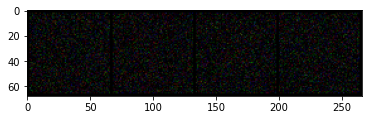

In [104]:
predict(model,valid_data_loader)